In [1]:
import graph_tool.all as gt
from math import sqrt

In [2]:
from random import *

In [3]:
from libs.community_detection.worker_selection import *
from libs.evaluation import *

In [4]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
formatedGraphPath="../graphs/formatted/"
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [5]:
import igraph as ig

In [6]:
F=ig.Graph.Read("../graphs/formatted/0.edges",format="ncol").as_undirected()

In [8]:
nbWorkers=10

In [9]:
%time F,workerIds,partition,clusterGraph,clusterIds=assignWorkers(F,nbWorkers)
print(workerIds)

igraph.Vertex(<igraph.Graph object at 0x7fb7c33dce50>, 1, {'name': 'C1', 'color': (1, 0.0, 0.4615384615384617), 'cluster': 1})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 14, {'name': 'V126', 'color': (1, 0.0, 0.4615384615384617), 'cluster': 1})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 0, {'name': 'V90', 'color': (0.0, 0.7692307692307692, 1), 'cluster': 11})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 0, {'name': 'V282', 'color': (0.5, 0.0, 0.0), 'cluster': 13})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 0, {'name': 'V233', 'color': (0.5, 0.0, 0.23076923076923084), 'cluster': 14})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 0, {'name': 'V33', 'color': (0.0, 0.3076923076923075, 1), 'cluster': 9})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 2, {'name': 'V327', 'color': (0.0, 1, 0.30769230769230793), 'cluster': 10})
igraph.Vertex(<igraph.Graph object at 0x7fb7c33dcc70>, 0, {'name': 'V270', 'color': (0.1538461538461533, 

### What if we distantiated workers based on the whole graph (as if one unique community)

%time workerIds=F.vs[maxShortestPathNodesSelection(F,nbWorkers)]["name"]

### Arbitrary workers

In [9]:
workerIds=['V2927', 'V2962', 'V1546', 'V2358', 'V1924', 'V1190', 'V2638', 'V3183', 'V4017', 'V2861', 'V1579', 'V609', 'V23', 'V3605', 'V3810', 'V3429', 'V3606', 'V2070', 'V1077', 'V2216', 'V189', 'V696', 'V2806', 'V182', 'V1878', 'V1109', 'V3435', 'V2700', 'V3997', 'V1764', 'V3486', 'V3953', 'V2444', 'V98', 'V2808', 'V1530', 'V256', 'V3033', 'V185', 'V588', 'V39', 'V1558', 'V2507', 'V1728', 'V1328', 'V181', 'V2701', 'V3660', 'V985', 'V3315', 'V399', 'V400', 'V1410', 'V126', 'V1444', 'V667', 'V2672', 'V2368', 'V197', 'V3974', 'V1586', 'V3424', 'V1726', 'V1066', 'V1561', 'V3054', 'V2582', 'V3897', 'V3386', 'V1114', 'V593', 'V447', 'V1182', 'V2760', 'V2654', 'V2033', 'V683', 'V878', 'V281', 'V2052', 'V2804', 'V840', 'V2130', 'V1469', 'V2148', 'V3745', 'V3093', 'V4004', 'V431', 'V572', 'V3539', 'V935', 'V3970', 'V2704', 'V3996', 'V762', 'V1349', 'V1927', 'V454', 'V3643']

## Plot

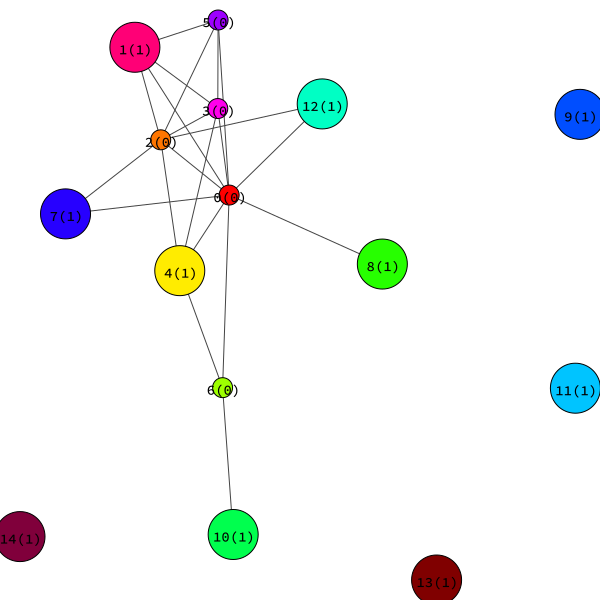

In [10]:
for idx, cluster in enumerate(clusterGraph.vs):
    if cluster.index in clusterIds:
        cluster["size"]=50
    cluster["color"]=partition.subgraph(idx).vs[0]["color"]
    cluster["label"]="{}({})".format(idx,cluster["nb_workers"])
ig.plot(clusterGraph)

In [11]:
for v in F.vs:
    if v["name"] in workerIds:
        v["size"]=25
        v["shape"]="triangle"
    else:
        v["size"]=1
        v["shape"]="circle"

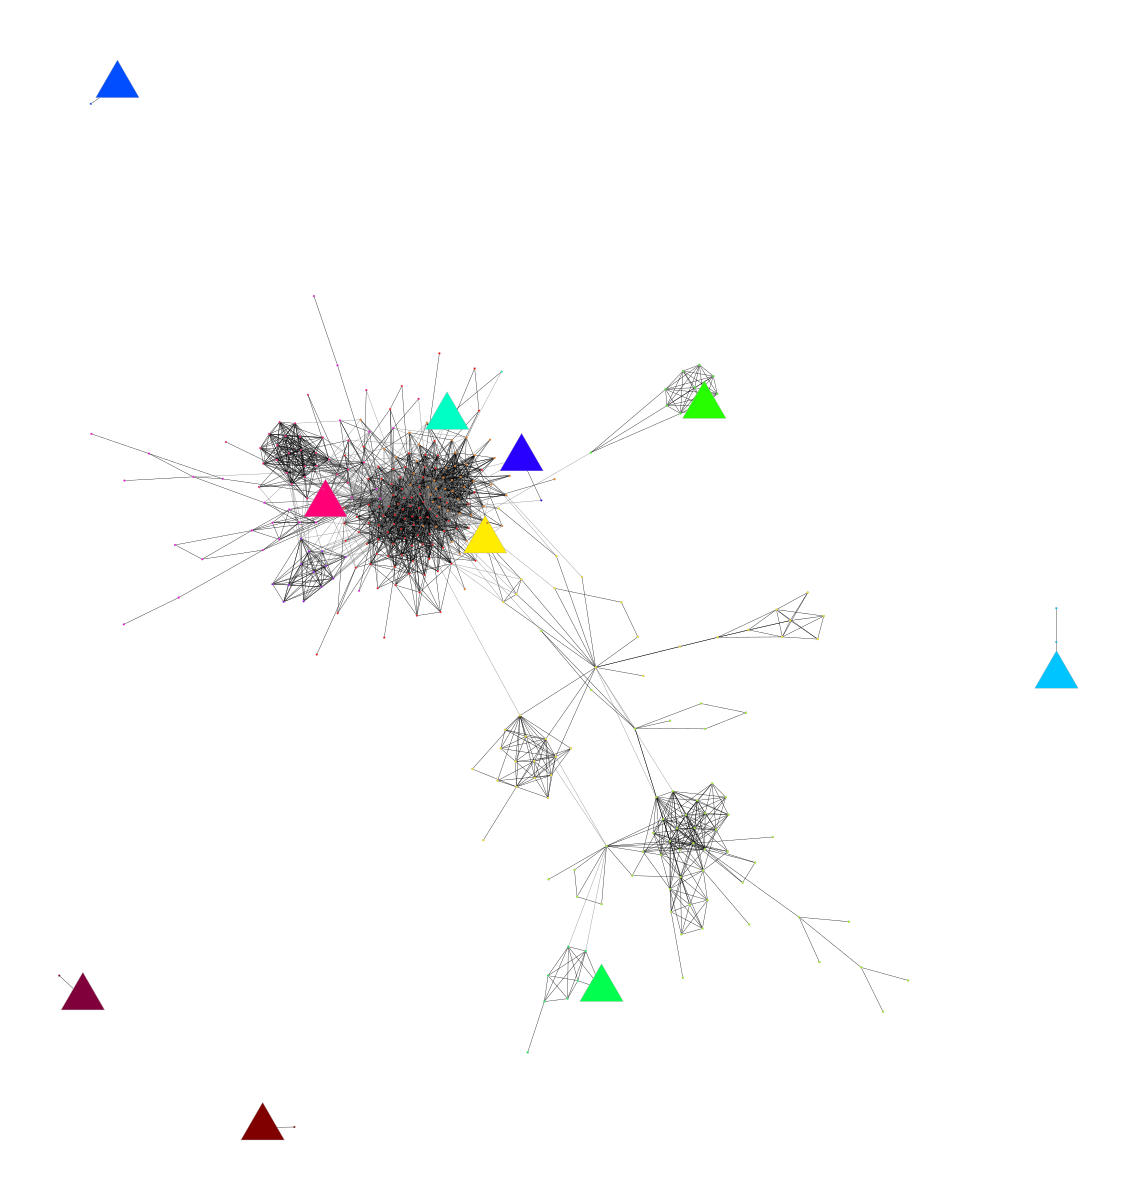

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb7c3226f70, at 0x7fb7c3052970>

In [12]:
G=F.to_graph_tool(vertex_attributes={"color":"vector<float>","size":"int","shape":"string"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],vertex_shape=G.vertex_properties["shape"],vertex_size=G.vertex_properties["size"],edge_color=G.edge_properties["color"])

## Evaluate

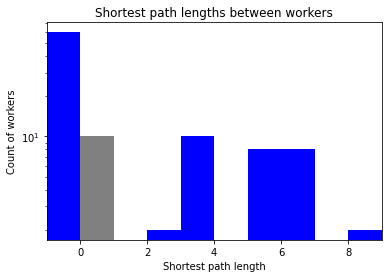

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import math
data=list(graphDistances(F,workerIds))
data=[[d if d!=math.inf else -1 for d in l] for l in data]
maxDist=max([max(l,default=0) for l in data],default=0)
colors=["grey","red","blue"]
labels=["self","same community","other community"]
# fixed bin size
bins = np.arange(-1, 100, 1) # fixed bin size

plt.xlim([-1, maxDist+1])
plt.yscale("log")
plt.hist(data, bins=bins, color=colors, label=labels, stacked=True)
plt.title('Shortest path lengths between workers')
plt.xlabel('Shortest path length')
plt.ylabel('Count of workers')

plt.show()

In [14]:
#the greater the value, the better
print(sum([sum(l) for l in data]))

37134


### Intra cluster distances

In [25]:
import numpy as np
from matplotlib import pyplot as plt

nbClusters=len(partition.subgraphs())
nbCol=4
fig,ax = plt.subplots(nrows = (nbClusters+nbCol)//nbCol, ncols = nbCol,sharex=True, sharey=True,figsize=(nbCol*4,3*nbClusters//nbCol))

for idx, subgraph in enumerate(partition.subgraphs()):
    inClusterWorkers=[w for w in workerIds if w in subgraph.vs["name"]]
    data=list(graphDistances(F,inClusterWorkers,workerIds,subgraph.vs[0]["cluster"]))
    colors=["grey","red","blue"]
    labels=["self","same community","other community"]

    # fixed bin size
    bins = np.arange(0, maxDist+1, 1) # fixed bin size

    ax[idx//nbCol][idx%nbCol].hist(data, bins=bins, color=colors, label=labels, stacked=True)
    ax[idx//nbCol][idx%nbCol].title.set_text('SPLs from {} worker{} in cluster {}'.format(len(inClusterWorkers),"s" if len(inClusterWorkers)>1 else "",idx))
fig.xlim=[0, maxDist+1]
fig.yscale="log"
fig.suptitle='Shortest path lengths between workers'
fig.xlabel='Shortest path length'
fig.ylabel='Count of workers'
#fig.savefig(imgPath)
plt.close(fig)

4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]
4 [4, 4, 4, 4]


## Graph Metrics

### Max distance between nodes (graph diameter)

In [16]:
print(F.diameter())

8


### Distances inter-nodes intra-clusters (cluster diameters)

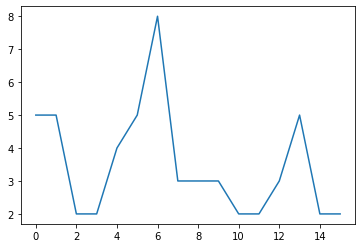

In [17]:
subgraphs=partition.subgraphs()
diameters=list([subgraph.diameter() for subgraph in subgraphs])
plt.plot(diameters)

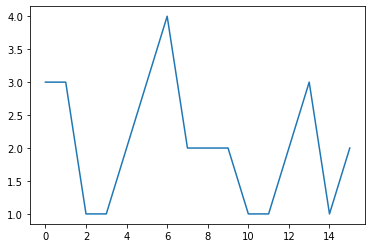

In [18]:
radii=list([subgraph.radius() for subgraph in subgraphs])
plt.plot(radii)

### Nodes per community

In [19]:
from collections import Counter
nbClusters=len(Counter(F.vs["cluster"]))

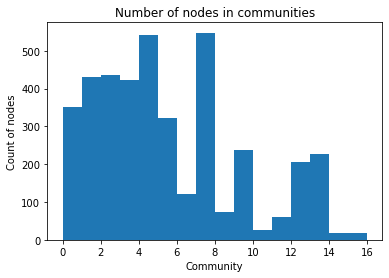

In [20]:
bins = np.arange(0, nbClusters+1, 1)
plt.hist(F.vs["cluster"], bins=bins)
plt.title('Number of nodes in communities')
plt.xlabel('Community')
plt.ylabel('Count of nodes')

plt.show()

### Workers per cluster

<function xlabel at 0x7f9cb0fc59d0>
[12, 14, 6, 7, 14, 9, 4, 12, 1, 5, 0, 4, 4, 6, 0, 2]


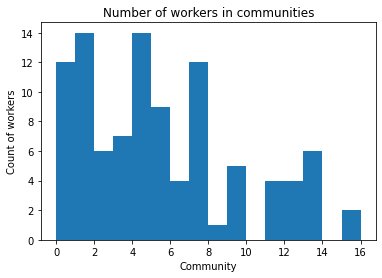

In [38]:
data=[F.vs.find(worker)["cluster"] for worker in workerIds]
bins = np.arange(0, nbClusters+1, 1)
plt.hist(data, bins=bins)
plt.title('Number of workers in communities')
plt.xlabel('Community')
plt.ylabel('Count of workers')

ax = plt.gca()
p = ax.patches
heights = [int(patch.get_height()) for patch in p]
print(heights)

#plt.show()

[]


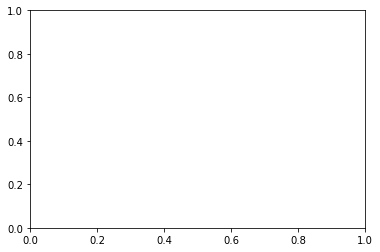

### Cluster diameter based worker count

In [22]:
diameters=[subgraph.diameter() for subgraph in partition.subgraphs()]

workers=[diameter//2+diameter%2 for diameter in diameters]
assignedWorkers=sum(workers)
print(assignedWorkers)

32


In [23]:
def closenessdCliques(graph, minDist, nodesSubset=None):
    nodes=graph.vs
    candidates=set()
    if nodesSubset is None:
        matPCC=graph.shortest_paths_dijkstra()
        nodesSubset=nodes["name"]
    else:
        nodesIdx=[graph.vs.find(n).index for n in nodesSubset]
        matPCC=graph.shortest_paths_dijkstra(nodesIdx,nodesIdx)
        print(np.size(matPCC))
    dfPCC=pd.DataFrame(matPCC,nodesSubset,nodesSubset)
    #print((dfPCC > minDist).values)
    restrictDf=(dfPCC.where((dfPCC <= minDist) & (dfPCC > 0))).values.tolist()
    g = ig.Graph.Adjacency(restrictDf).as_undirected()
    g.vs["name"]=nodesSubset
    ig.plot(g,"../graphs/img/graph.png")
    print(len(g.vs))
    try:
        cliques=deadline(30)(g.largest_cliques)()
        candidates=[[nodesSubset[idx] for idx in clique] for clique in cliques]
        
        print("n_clq",len(cliques),"l_clq", len(cliques[0]),"a clq", cliques[0])
        print("len(c)",len(candidates[0]),"len(n)",len(nodesSubset))
        yield candidates
    except TimeoutException:
        print("Timeout")
        candidates=None
    return candidates

In [26]:
list(closenessCliques(F,2,workerIds))

10000
100
n_clq 10525156 l_clq 1 a clq (62,)
len(c) 10525156 len(n) 100


[[['V1726'],
  ['V431'],
  ['V2148'],
  ['V3643'],
  ['V189'],
  ['V3996'],
  ['V840'],
  ['V1182'],
  ['V1182', 'V2148'],
  ['V1726', 'V1182'],
  ['V2760'],
  ['V1726', 'V2760'],
  ['V400'],
  ['V400', 'V431'],
  ['V1927'],
  ['V2148', 'V1927'],
  ['V3970'],
  ['V3970', 'V3643'],
  ['V281'],
  ['V189', 'V281'],
  ['V4004'],
  ['V4004', 'V3996'],
  ['V762'],
  ['V840', 'V762'],
  ['V878'],
  ['V878', 'V840'],
  ['V1114'],
  ['V400', 'V1114'],
  ['V400', 'V1114', 'V431'],
  ['V1114', 'V1182'],
  ['V1726', 'V1114', 'V1182'],
  ['V1114', 'V431'],
  ['V1726', 'V1114'],
  ['V3386'],
  ['V3386', 'V2760'],
  ['V1726', 'V3386', 'V2760'],
  ['V1726', 'V3386'],
  ['V2052'],
  ['V2052', 'V1927'],
  ['V2052', 'V2148', 'V1927'],
  ['V1182', 'V2052'],
  ['V1182', 'V2052', 'V2148'],
  ['V2052', 'V2148'],
  ['V3539'],
  ['V3539', 'V3970'],
  ['V3539', 'V3970', 'V3643'],
  ['V3539', 'V3643'],
  ['V197'],
  ['V197', 'V281'],
  ['V189', 'V197', 'V281'],
  ['V189', 'V197'],
  ['V593'],
  ['V400', 'V593'],

In [25]:
graph.get_shortest_paths

NameError: name 'graph' is not defined

In [3]:
d=8
minDist=lambda d:range(4,d+1)
minDist(d)

range(4, 9)